# generating embeddings with model trained with cls-pooling vs Xpressor layers


In [ ]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scprint.tasks import GeneEmbeddingExtractor
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scipy.stats import spearmanr
from anndata import AnnData

from grnndata.utils import TF, file_dir
import gseapy as gp

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/" #"../..data/"  #

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/lamindb/core/storage/_anndata_accessor.py:12: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/lamindb/core/storage/_zarr.py:6: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [1]:
adata = sc.read(
    LOC + "temp/glio_smart_highdepth" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

max_len = 4000 if adata.X.sum(1).mean() < 10_000 else 8000
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=True,
)
print("")
print(adata.X.sum(1).mean())
adata = preprocessor(adata)


388362.5
Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 3589 renamining
filtered out 22 cells, 3567 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 47967 genes in the ontology but not present in the dataset
starting QC
Seeing 71 outliers (1.99% of total dataset):
normalize
starting PCA
done
AnnData object with n_obs × n_vars = 3567 × 70116
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_o

In [ ]:
m = torch.load(model_checkpoint_file, map_location="cpu")

In [ ]:
m["hyper_parameters"]["label_decoders"] = {
    k: {u: j if j is not None else "None" for u, j in v.items()}
    for k, v in m["hyper_parameters"]["label_decoders"].items()
}

In [ ]:
rn = {
    "expr_encoder.encoder.2.weight": "expr_encoder.encoder.1.weight",
    "expr_encoder.encoder.2.bias": "expr_encoder.encoder.1.bias",
    "expr_encoder.encoder.6.weight": "expr_encoder.encoder.5.weight",
    "expr_encoder.encoder.6.bias": "expr_encoder.encoder.5.bias",
    "expr_decoder.fc.2.weight": "expr_decoder.fc.1.weight",
    "expr_decoder.fc.2.bias": "expr_decoder.fc.1.bias",
    "expr_decoder.fc.6.weight": "expr_decoder.fc.5.weight",
    "expr_decoder.fc.6.bias": "expr_decoder.fc.5.bias",
}
m["state_dict"] = {k if k not in rn else rn[k]: v for k, v in m["state_dict"].items()}

m["hyper_parameters"].pop("checkpointing")
m["hyper_parameters"].pop("residual_in_fp32")
m["hyper_parameters"].pop("fused_dropout_add_ln")
m["hyper_parameters"].pop("checkpointing")
m["hyper_parameters"].pop("fused_mlp")
m["hyper_parameters"].pop("fused_bias_fc")
m["hyper_parameters"].pop("drop_path_rate")
m["hyper_parameters"].pop("class_compression")
m["hyper_parameters"].pop("depth_atinput")
m["hyper_parameters"].pop("cell_transformer_layers")
m["hyper_parameters"].pop("residual_in_fp32")

In [ ]:
torch.save(m, model_checkpoint_file)

In [36]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
LOC2 = "../"  # "../../../"
model_checkpoint_file = LOC2 + "models/18hebyht-final-small.ckpt"
# model_checkpoint_file = "../../../psqzicou.ckpt"
# w937u4o1

In [ ]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

In [8]:
adata.obs.cell_type.value_counts()

cell_type
myeloid cell                      1842
neoplastic cell                   1079
oligodendrocyte precursor cell     406
astrocyte                           88
oligodendrocyte                     81
vascular lymphangioblast            50
neuron                              21
Name: count, dtype: int64

In [35]:
cell_type = "oligodendrocyte"
extractor = GeneEmbeddingExtractor(
    genelist=adata.var.index[
        np.array(
            (adata[adata.obs.cell_type == cell_type].X > 0).sum(0)
            > (adata.obs.cell_type.value_counts()[cell_type] * 0.3)
        )[0]
    ].tolist(),
    batch_size=16,
    num_workers=8,
    average=False,
)

# model 1


In [ ]:
gemb_da = extractor(model, adata[adata.obs.cell_type == cell_type, :])

Using 100.00% of the genes in the gene list


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


In [ ]:
gemb_da.varm["gene_embeddings"] = gemb_da.uns["all_embeddings"][0]

In [ ]:
gemb_da = gemb_da.T

In [ ]:
gemb_da.obsm["gene_pca"] = sc.pp.pca(
    gemb_da.obsm["gene_embeddings"], n_comps=30, use_highly_variable=False
)

sc.pp.neighbors(
    gemb_da,
    use_rep="gene_pca",  # can be a plain NumPy / sparse array
    n_neighbors=15,
    key_added="gene_neighbors",  # keeps it separate from the cell graph
)

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [ ]:
sc.tl.umap(
    gemb_da,
    neighbors_key="gene_neighbors",  # tells Scanpy which graph to use
    init_pos="spectral",
    random_state=0,
    min_dist=0.3,
)

In [ ]:
genes = load_genes(["NCBITaxon:9606"])

In [ ]:
gemb_da.obs = genes.loc[gemb_da.obs.index]

In [ ]:
gemb_da.obs["expression"] = np.log(1 + gemb_da.X[:, 0])
gemb_da.obs["zero_expression"] = gemb_da.X[:, 0] == 0

In [ ]:
sc.tl.leiden(
    gemb_da,
    neighbors_key="gene_neighbors",
    resolution=1.0,
    key_added="leiden",
    flavor="igraph",
    random_state=42,
)  # use weights to get more clusters

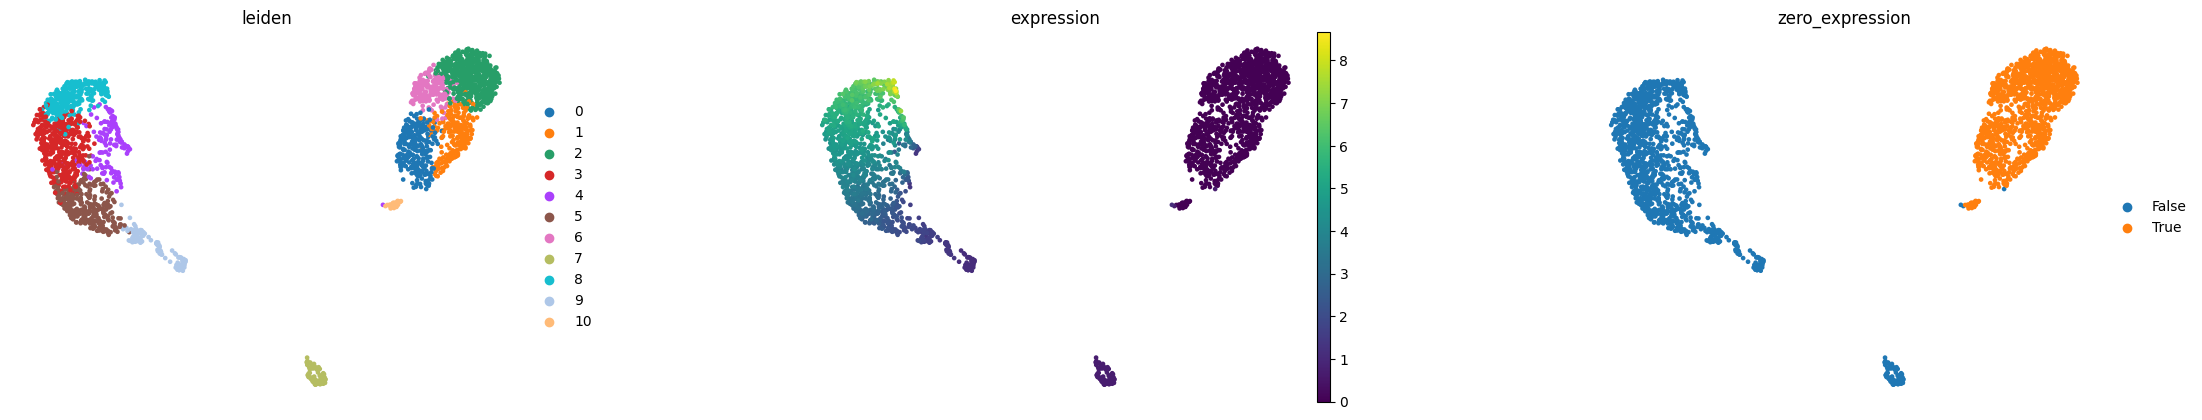

In [ ]:
sc.pl.umap(
    gemb_da,
    color=["leiden", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)

In [ ]:
# lots of PPI hub and chromosome location, mircro<RNA, TF chip-seq 2 GO MF, 1 GO CC Nucleus

In [ ]:
gene_sets = [
    # "KEGG_2021_Human",
    # "ENCODE_TF_ChIP-seq_2015",
    # "GO_Molecular_Function_2025",
    # {"TFs": TF},
    # file_dir + "/celltype.gmt",
    # "OMIM_Disease",
    # "WikiPathways_2024_Human",
    # "GO_Cellular_Component_2025",
    # "GTEx_Tissues_V8_2023",
    # "TargetScan_microRNA",
    # "Chromosome_Location",
    # "PPI_Hub_Proteins",
]

pre_res = gp.enrich(
    gene_list=gemb_da.obs.symbol[
        gemb_da.obs["leiden"] == "5"
    ].tolist(),  # or rnk = rnk,
    gene_sets=gene_sets,
    background=gemb_da.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
    outdir=None,
    verbose=True,
)

pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05]

2025-08-07 14:12:33,630 [INFO] Run: OMIM_Disease 
2025-08-07 14:12:34,562 [INFO] Done.


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes


In [24]:
for gs in [
    "KEGG_2021_Human",
    "GO_Molecular_Function_2025",
    "WikiPathways_2024_Human",
    "GO_Cellular_Component_2025",
]:
    elems = 0
    for cluster in gemb_da.obs["leiden"].cat.categories:

        pre_res = gp.enrich(
            gene_list=gemb_da.obs.symbol[
                gemb_da.obs["leiden"] == cluster
            ].tolist(),  # or rnk = rnk,
            gene_sets=gs,
            background=gemb_da.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
            outdir=None,
            verbose=True,
        )

        elems += len(pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05])
    print(gs, elems)

2025-10-28 12:35:47,220 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:48,265 [INFO] Done.
2025-10-28 12:35:48,780 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:49,772 [INFO] Done.
2025-10-28 12:35:50,317 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:51,379 [INFO] Done.
2025-10-28 12:35:51,968 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:53,024 [INFO] Done.
2025-10-28 12:35:53,553 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:54,515 [INFO] Done.
2025-10-28 12:35:55,038 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:55,994 [INFO] Done.
2025-10-28 12:35:56,534 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:57,480 [INFO] Done.
2025-10-28 12:35:58,015 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:35:58,978 [INFO] Done.
2025-10-28 12:35:59,517 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:36:00,477 [INFO] Done.
2025-10-28 12:36:00,995 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:36:01,948 [INFO] Done.
2025-10-28 12:36:02,465 [INFO] Run: KEGG_2021_Human 
2025-10-28 12:36:03,337 [INFO] Done.


KEGG_2021_Human 72


2025-10-28 12:36:03,873 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:04,909 [INFO] Done.
2025-10-28 12:36:05,448 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:06,494 [INFO] Done.
2025-10-28 12:36:07,005 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:08,059 [INFO] Done.
2025-10-28 12:36:08,591 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:09,634 [INFO] Done.
2025-10-28 12:36:10,162 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:11,129 [INFO] Done.
2025-10-28 12:36:11,639 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:12,677 [INFO] Done.
2025-10-28 12:36:13,212 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:14,191 [INFO] Done.
2025-10-28 12:36:14,717 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:15,661 [INFO] Done.
2025-10-28 12:36:16,192 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:17,279 [INFO] Done.
2025-10-28 12:36:17,788 [INFO] Run: GO_Molecular_Function_2025 
2025-10-28 12:36:18,763 [IN

GO_Molecular_Function_2025 15


2025-10-28 12:36:20,696 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:21,768 [INFO] Done.
2025-10-28 12:36:22,299 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:23,339 [INFO] Done.
2025-10-28 12:36:23,872 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:24,934 [INFO] Done.
2025-10-28 12:36:25,463 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:26,536 [INFO] Done.
2025-10-28 12:36:27,071 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:28,064 [INFO] Done.
2025-10-28 12:36:28,593 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:29,635 [INFO] Done.
2025-10-28 12:36:30,177 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:31,156 [INFO] Done.
2025-10-28 12:36:31,688 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:32,663 [INFO] Done.
2025-10-28 12:36:33,175 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:34,241 [INFO] Done.
2025-10-28 12:36:34,780 [INFO] Run: WikiPathways_2024_Human 
2025-10-28 12:36:35,738 [INFO] Done.
2025-10-28 12:36:36,

WikiPathways_2024_Human 20


2025-10-28 12:36:37,694 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:38,731 [INFO] Done.
2025-10-28 12:36:39,263 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:40,237 [INFO] Done.
2025-10-28 12:36:40,752 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:41,800 [INFO] Done.
2025-10-28 12:36:42,321 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:43,325 [INFO] Done.
2025-10-28 12:36:43,856 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:44,848 [INFO] Done.
2025-10-28 12:36:45,354 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:46,396 [INFO] Done.
2025-10-28 12:36:46,929 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:47,857 [INFO] Done.
2025-10-28 12:36:48,383 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:49,333 [INFO] Done.
2025-10-28 12:36:49,866 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:50,840 [INFO] Done.
2025-10-28 12:36:51,380 [INFO] Run: GO_Cellular_Component_2025 
2025-10-28 12:36:52,356 [IN

GO_Cellular_Component_2025 41


In [34]:
from scipy.stats import ttest_ind, ttest_rel
import pandas as pd

cols = ["xpressor_generator", "no_xpressor"]
data = {
    "GO_Cellular_Component_2025": [41, 20],
    "WikiPathways_2024_Human": [20, 23],
    "GO_Molecular_Function_2025": [15, 2],
    "KEGG_2021_Human": [72, 23],
}

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data, index=cols).T

# Paired t-test (since comparing same gene sets)
t_stat, p_value = ttest_rel(df["xpressor_generator"], df["no_xpressor"])

print(f"Paired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Independent t-test (if you prefer)
t_stat_ind, p_value_ind = ttest_ind(df["xpressor_generator"], df["no_xpressor"])

print(f"\nIndependent t-test results:")
print(f"t-statistic: {t_stat_ind:.4f}")
print(f"p-value: {p_value_ind:.4f}")

# Summary statistics
print(f"\nMean enrichments:")
print(f"Xpressor generator: {df['xpressor_generator'].mean():.2f} ± {df['xpressor_generator'].std():.2f}")
print(f"No xpressor: {df['no_xpressor'].mean():.2f} ± {df['no_xpressor'].std():.2f}")

Paired t-test results:
t-statistic: 1.8386
p-value: 0.1633

Independent t-test results:
t-statistic: 1.4384
p-value: 0.2004

Mean enrichments:
Xpressor generator: 37.00 ± 25.91
No xpressor: 17.00 ± 10.10


# second model without XPressor


In [21]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
LOC2 = "../"  # "../../../"
model_checkpoint_file = LOC2 + "models/z3abxa21-nogen.ckpt"
# model_checkpoint_file = "../../../psqzicou.ckpt"
# ogvvg2z7-v1
# w937u4o1

In [22]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [23]:
gemb_da_2 = extractor(model, adata[adata.obs.cell_type == cell_type, :])

Using 100.00% of the genes in the gene list


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


In [24]:
gemb_da_2.varm["gene_embeddings"] = gemb_da_2.uns["all_embeddings"].mean(0)

In [25]:
gemb_da_2 = gemb_da_2.T

In [26]:
gemb_da_2.obsm["gene_pca"] = sc.pp.pca(
    gemb_da_2.obsm["gene_embeddings"], n_comps=30, use_highly_variable=False
)

sc.pp.neighbors(
    gemb_da_2,
    use_rep="gene_pca",  # can be a plain NumPy / sparse array
    n_neighbors=15,
    key_added="gene_neighbors",  # keeps it separate from the cell graph
)

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [27]:
sc.tl.umap(
    gemb_da_2,
    neighbors_key="gene_neighbors",  # tells Scanpy which graph to use
    init_pos="spectral",
    random_state=0,
    min_dist=0.3,
)

In [28]:
genes = load_genes(["NCBITaxon:9606"])

In [29]:
gemb_da_2.obs = genes.loc[gemb_da_2.obs.index]

In [30]:
gemb_da_2.obs["expression"] = np.log(1 + gemb_da_2.X[:, 0])
gemb_da_2.obs["zero_expression"] = gemb_da_2.X[:, 0] == 0

In [31]:
sc.tl.leiden(
    gemb_da_2,
    neighbors_key="gene_neighbors",
    resolution=1.0,
    key_added="leiden",
    flavor="igraph",
    random_state=42,
)  # use weights to get more clusters

... storing 'biotype' as categorical
... storing 'organism' as categorical


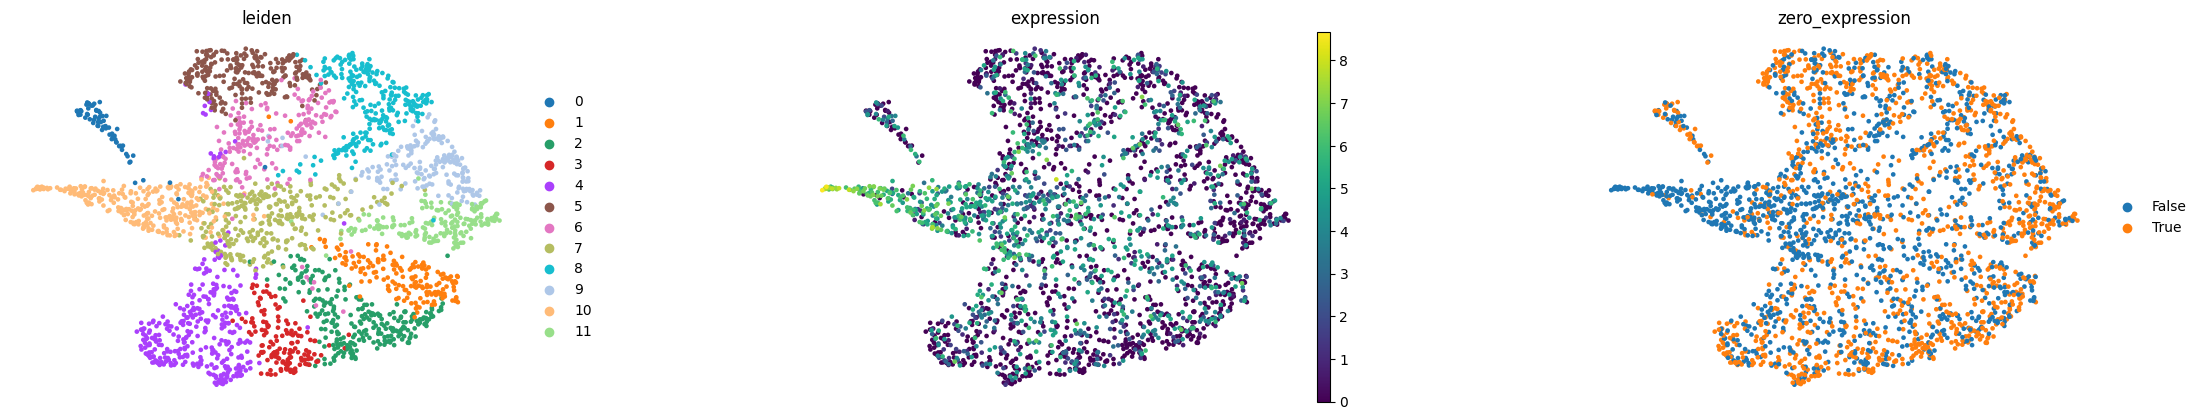

In [32]:
sc.pl.umap(
    gemb_da_2,
    color=["leiden", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)  # mean of all

0 go MF, 0 CC, 0 TF chip seq...


In [33]:
for gs in [
    "KEGG_2021_Human",
    "GO_Molecular_Function_2025",
    "WikiPathways_2024_Human",
    "GO_Cellular_Component_2025",
]:
    elems = 0
    for cluster in gemb_da_2.obs["leiden"].cat.categories:

        pre_res = gp.enrich(
            gene_list=gemb_da_2.obs.symbol[
                gemb_da_2.obs["leiden"] == cluster
            ].tolist(),  # or rnk = rnk,
            gene_sets=gs,
            background=gemb_da_2.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
            outdir=None,
            verbose=True,
        )

        elems += len(pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05])
    print(gs, elems)

2025-11-02 16:30:52,394 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:30:53,462 [INFO] Done.
2025-11-02 16:30:54,095 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:30:55,147 [INFO] Done.
2025-11-02 16:30:55,721 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:30:56,774 [INFO] Done.
2025-11-02 16:30:57,340 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:30:58,379 [INFO] Done.
2025-11-02 16:30:58,940 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:31:00,045 [INFO] Done.
2025-11-02 16:31:00,604 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:31:01,644 [INFO] Done.
2025-11-02 16:31:02,207 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:31:03,231 [INFO] Done.
2025-11-02 16:31:03,783 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:31:04,924 [INFO] Done.
2025-11-02 16:31:05,486 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:31:06,515 [INFO] Done.
2025-11-02 16:31:07,070 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:31:08,128 [INFO] Done.
2025-11-02 16:31:08,665 [INFO] Run: KEGG_2021_Human 
2025-11-02 16:31:09,699 [INFO] Done.
2025-11-02

KEGG_2021_Human 23


2025-11-02 16:31:11,853 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:12,900 [INFO] Done.
2025-11-02 16:31:13,437 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:14,510 [INFO] Done.
2025-11-02 16:31:15,066 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:16,160 [INFO] Done.
2025-11-02 16:31:16,727 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:17,789 [INFO] Done.
2025-11-02 16:31:18,322 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:19,446 [INFO] Done.
2025-11-02 16:31:20,005 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:21,127 [INFO] Done.
2025-11-02 16:31:21,685 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:22,833 [INFO] Done.
2025-11-02 16:31:23,405 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:24,557 [INFO] Done.
2025-11-02 16:31:25,117 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:26,236 [INFO] Done.
2025-11-02 16:31:26,789 [INFO] Run: GO_Molecular_Function_2025 
2025-11-02 16:31:27,908 [IN

GO_Molecular_Function_2025 2


2025-11-02 16:31:31,834 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:32,865 [INFO] Done.
2025-11-02 16:31:33,423 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:34,556 [INFO] Done.
2025-11-02 16:31:35,103 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:36,241 [INFO] Done.
2025-11-02 16:31:36,802 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:37,840 [INFO] Done.
2025-11-02 16:31:38,404 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:39,549 [INFO] Done.
2025-11-02 16:31:40,086 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:41,207 [INFO] Done.
2025-11-02 16:31:41,740 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:42,861 [INFO] Done.
2025-11-02 16:31:43,416 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:44,539 [INFO] Done.
2025-11-02 16:31:45,110 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:46,266 [INFO] Done.
2025-11-02 16:31:46,823 [INFO] Run: WikiPathways_2024_Human 
2025-11-02 16:31:47,928 [INFO] Done.
2025-11-02 16:31:48,

WikiPathways_2024_Human 23


2025-11-02 16:31:51,819 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:31:52,870 [INFO] Done.
2025-11-02 16:31:53,431 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:31:54,478 [INFO] Done.
2025-11-02 16:31:55,010 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:31:56,055 [INFO] Done.
2025-11-02 16:31:56,625 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:31:57,661 [INFO] Done.
2025-11-02 16:31:58,220 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:31:59,365 [INFO] Done.
2025-11-02 16:31:59,933 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:32:00,971 [INFO] Done.
2025-11-02 16:32:01,537 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:32:02,557 [INFO] Done.
2025-11-02 16:32:03,111 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:32:04,185 [INFO] Done.
2025-11-02 16:32:04,737 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:32:05,772 [INFO] Done.
2025-11-02 16:32:06,320 [INFO] Run: GO_Cellular_Component_2025 
2025-11-02 16:32:07,388 [IN

GO_Cellular_Component_2025 20


In [ ]:
gene_sets = [
    # "KEGG_2021_Human",
    # "ENCODE_TF_ChIP-seq_2015",
    # "GO_Molecular_Function_2025",
    # {"TFs": TF},
    # file_dir + "/celltype.gmt",
    # "OMIM_Disease",
    # "WikiPathways_2024_Human",
    # "GO_Cellular_Component_2025",
    # "GTEx_Tissues_V8_2023",
    # "TargetScan_microRNA",
    # "Chromosome_Location",
    "PPI_Hub_Proteins",
]

pre_res = gp.enrich(
    gene_list=gemb_da_2.obs.symbol[
        gemb_da_2.obs["leiden"] == "0"
    ].tolist(),  # or rnk = rnk,
    gene_sets=gene_sets,
    background=gemb_da_2.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
    outdir=None,
    verbose=True,
)

pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05]

2025-08-07 14:13:58,084 [INFO] Run: PPI_Hub_Proteins 
2025-08-07 14:13:59,257 [INFO] Done.


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes


... storing 'biotype' as categorical
... storing 'organism' as categorical


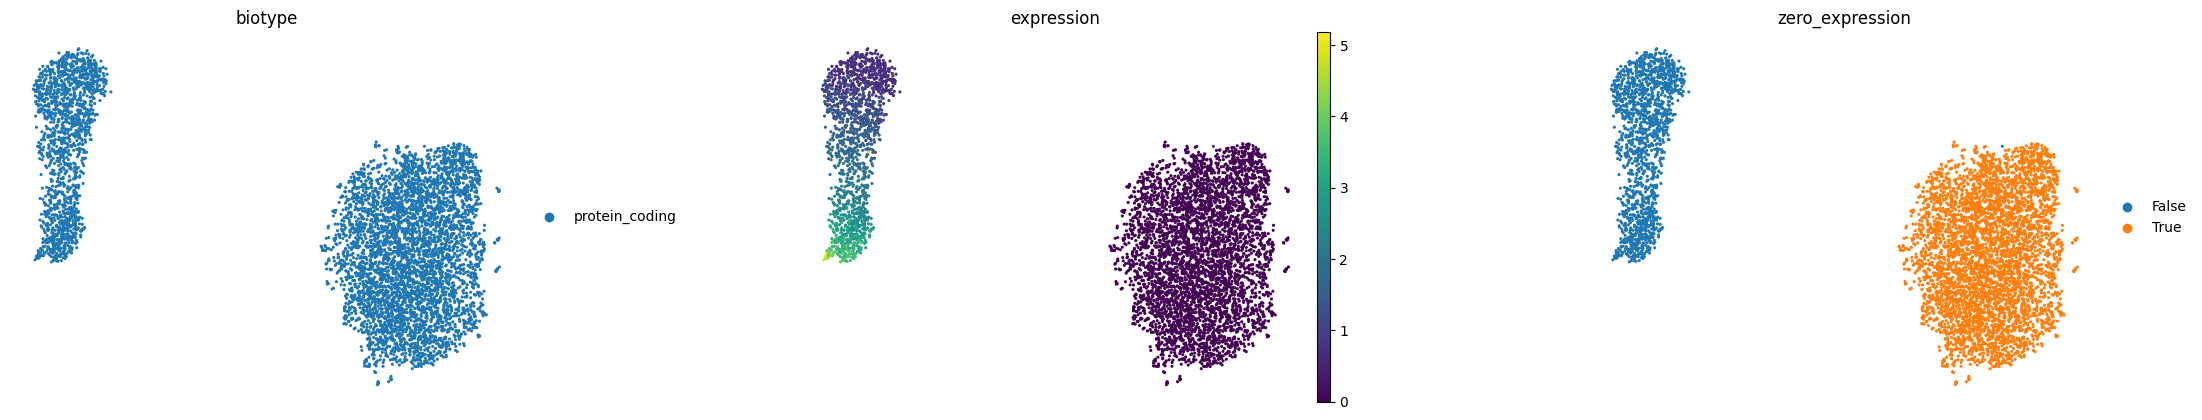

In [42]:
sc.pl.umap(
    gemb_da_2,
    color=["biotype", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)